In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# pip install shapely
# conda install --channel conda-forge shapely
# pip install descartes

# https://pypi.org/project/Shapely/
# https://shapely.readthedocs.io/en/latest/manual.html
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import Polygon

from descartes.patch import PolygonPatch

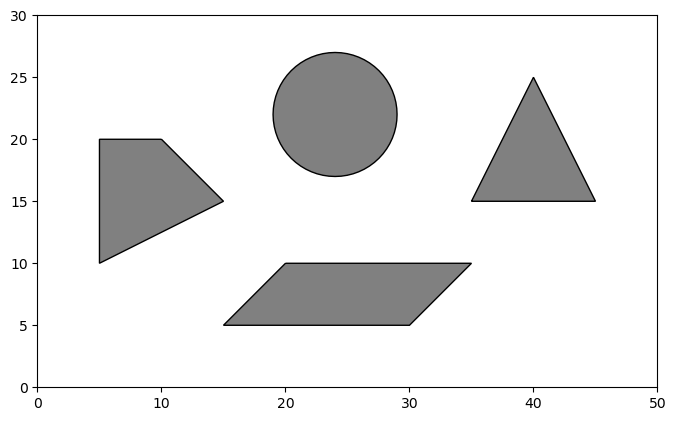

In [2]:
WORLDX, WORLDY = 50, 30 

# Criando obstáculos
obs1 = Polygon([(10, 20), (5, 20), (5, 10), (15, 15)])
obs2 = Polygon([(35, 15), (40, 25), (45, 15)])
obs3 = Polygon([(20, 10), (15, 5), (30, 5), (35, 10)])
obs4 = Point([24, 22]).buffer(5)

obs_set = [obs1, obs2, obs3, obs4]

# Método para plotar o mapa
def plot_map(obs_set):

    fig = plt.figure(figsize=(8,5), dpi=100)
    ax = fig.add_subplot(111, aspect='equal') 

    for obs in obs_set:
        ax.add_patch(PolygonPatch(obs, facecolor='gray'))
        
    ax.set_xlim(0, WORLDX)
    ax.set_ylim(0, WORLDY)

    
plot_map(obs_set)

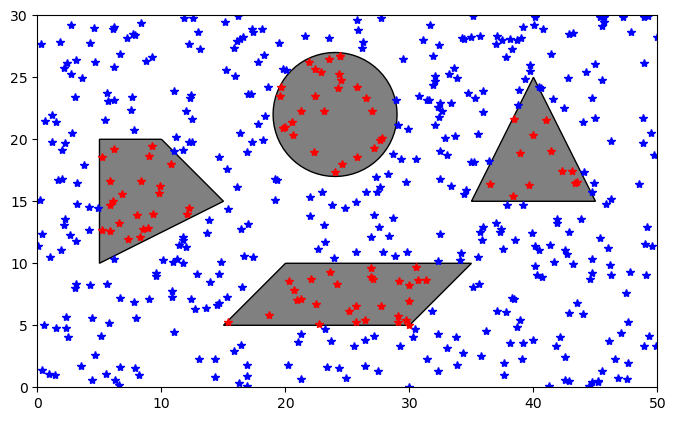

In [11]:
N = 500

# Gerando amostras aleatóras
samples = []
for n in range(N):
    x = np.random.uniform(0, WORLDX)
    y = np.random.uniform(0, WORLDY)
    samples.append(Point([x, y]))
    
    
# Verificando as que são inválidas    
invalid_samples = []
for s in samples:
    for o in obs_set:
        if s.intersects(o):
            invalid_samples.append(s)

            
# Salvando as amostras válidas em um vetor específico
valid_samples = list(filter(lambda samples: samples not in invalid_samples, samples))
    
plot_map(obs_set)
            
for v in valid_samples:
    plt.plot(*v.xy, 'b*')
    
for i in invalid_samples:
    plt.plot(*i.xy, 'r*')

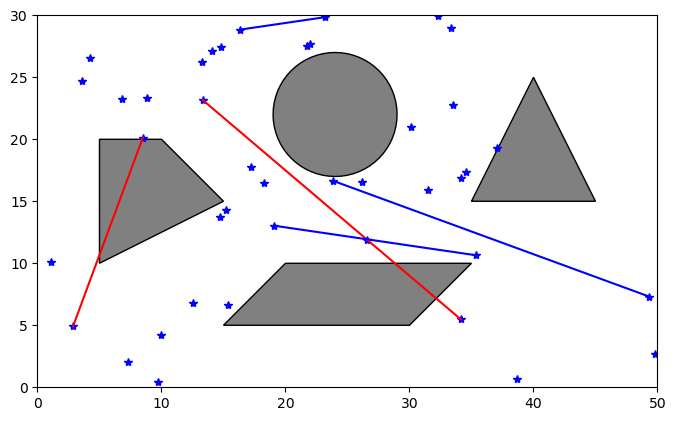

In [10]:
plot_map(obs_set)
            
for v in valid_samples:
    plt.plot(*v.xy, 'b*')
    
# Selecionado pares amostras aleatórias e verificando se o caminho é válido
for i in range(5):
    points = random.sample(valid_samples, 2)
    line = LineString(points)

    c = 'blue'
    for o in obs_set:
        if line.intersects(o):
            c = 'red'
    
    x, y = line.xy
    plt.gca().plot(x, y, color=c)

# Local planner

(0.0, 30.0)

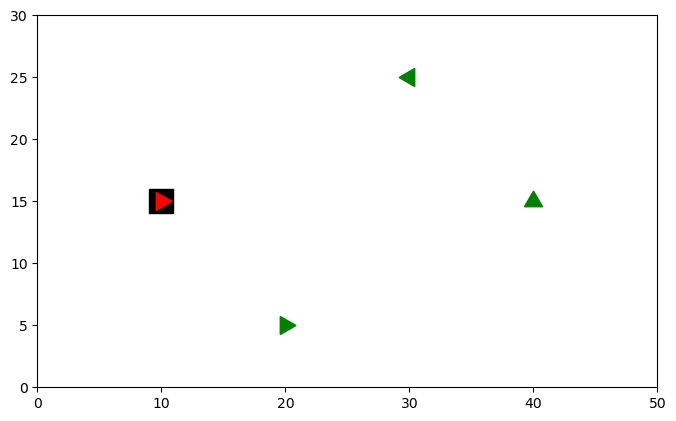

In [13]:
# (x, y, th)
robot = np.array([10, 15, 0])

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

plt.plot(robot[0], robot[1], marker=(4, 0, np.rad2deg(robot[2])-45), markersize=25, color='k')
plt.plot(robot[0], robot[1], marker=(3, 0, np.rad2deg(robot[2])-90), markersize=15, color='r')


# Simulando pontos aleatórios
p1 = np.array([30, 25, -np.pi])
p2 = np.array([40, 15, np.pi/2])
p3 = np.array([20, 5, 0])

plt.plot(p1[0], p1[1], marker=(3, 0, np.rad2deg(p1[2])-90), markersize=15, color='g')
plt.plot(p2[0], p2[1], marker=(3, 0, np.rad2deg(p2[2])-90), markersize=15, color='g')
plt.plot(p3[0], p3[1], marker=(3, 0, np.rad2deg(p3[2])-90), markersize=15, color='g')

ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)

(0.0, 30.0)

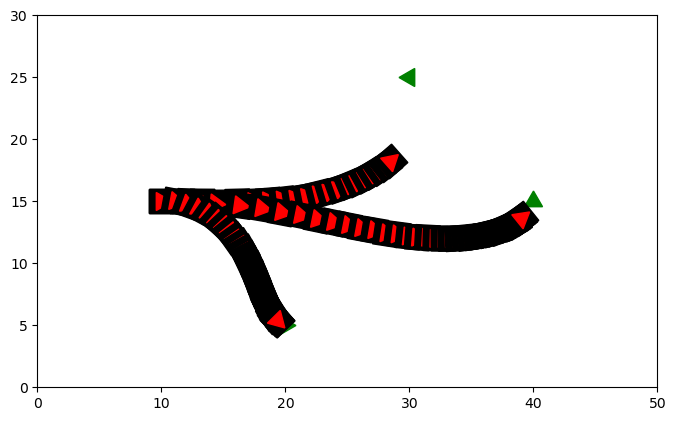

In [14]:
# Forward simulation (Euler's method)

# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod( angle+np.pi, 2*np.pi) - np.pi;

def controller(robot, goal, dt=0.1, Tmax=10):

    path = []
    
    t = 0
    while t < Tmax:

        path.append(robot)
        dx, dy, dth = goal - robot

        rho = np.sqrt(dx**2 + dy**2)
        alpha = normalizeAngle(-robot[2] + np.arctan2(dy,dx))
        beta = normalizeAngle(goal[2] - np.arctan2(dy,dx))
       
        kr = 3 / 20
        ka = 8 / 20
        kb = -1.5 / 20

        # Alvo na parte de trás
        if abs(alpha) > np.pi/2:
            kr = -kr       
            alpha = normalizeAngle(alpha-np.pi)
            beta = normalizeAngle(beta-np.pi)

        v = kr*rho
        w = ka*alpha + kb*beta
       
        M = np.array([[np.cos(robot[2]), 0], [np.sin(robot[2]), 0], [0, 1]])
        u = np.array([v, w])
        
        robot = robot + (M @ u)*dt    
        
        t = t + dt
    
    return np.array(path)

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

plt.plot(p1[0], p1[1], marker=(3, 0, np.rad2deg(p1[2])-90), markersize=15, color='g')
plt.plot(p2[0], p2[1], marker=(3, 0, np.rad2deg(p2[2])-90), markersize=15, color='g')
plt.plot(p3[0], p3[1], marker=(3, 0, np.rad2deg(p3[2])-90), markersize=15, color='g')

path1 = controller(robot, p1, dt=0.5, Tmax=10)
for q in path1:
    plt.plot(q[0], q[1], marker=(4, 0, np.rad2deg(q[2])-45), markersize=25, color='k')
    plt.plot(q[0], q[1], marker=(3, 0, np.rad2deg(q[2])-90), markersize=15, color='r')  

path2 = controller(robot, p2, dt=0.5, Tmax=20)
for q in path2:
    plt.plot(q[0], q[1], marker=(4, 0, np.rad2deg(q[2])-45), markersize=25, color='k')
    plt.plot(q[0], q[1], marker=(3, 0, np.rad2deg(q[2])-90), markersize=15, color='r')  

path3 = controller(robot, p3, dt=0.5, Tmax=20)
for q in path3:
    plt.plot(q[0], q[1], marker=(4, 0, np.rad2deg(q[2])-45), markersize=25, color='k')
    plt.plot(q[0], q[1], marker=(3, 0, np.rad2deg(q[2])-90), markersize=15, color='r')  
    
ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)    

# Para praticar

- Construa todo o grafo a partir das amostras.
- Faça testes considernado o Workspace e o Configuration Space.
- Crie vários Start/Goal e execute diferentes buscas no grafo.
- Implemente um controlador para que o robô consiga navegar no grafo.